# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)#origin true

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [7]:
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        # 计算交叉熵损失
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)

        # 计算焦点损失
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        return focal_loss.mean()

#### Method：Reset The Model

In [9]:
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [10]:
##################### Write your answer here ##################
# Define the loss function
# criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
# criterion = FocalLoss(gamma=0.5)
# criterion = FocalLoss(gamma=2)
###############################################################

In [11]:
def train_batch(model, image, target, criterion):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

def wrapper(func):
    def new_func(model,image,target,criterion):
        target=F.one_hot(target,num_classes=10).float()
        return func(model,image,target,criterion)
    return new_func

In [12]:
def test_batch(model, image, target, criterion):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

def wrapper(func):
    def new_func(model,image,target,criterion):
        target=F.one_hot(target,num_classes=10).float()
        return func(model,image,target,criterion)
    return new_func

### Model Training

In [13]:
def modeltraining(func1,func2,criterion):

    training_loss = []
    training_acc = []
    testing_loss = []
    testing_acc = []
    
    training_precision = []
    training_recall = []
    training_f1 = []
    
    testing_precision = []
    testing_recall = []
    testing_f1 = []
    
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        torch.cuda.empty_cache()

        ##########################
        ### Training
        ##########################

        running_cls_loss = 0.0
        running_cls_corrects = 0
        
        all_preds = []
        all_targets = []

        for batch_idx, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            target = target.to(device)

            # train model
            outputs, loss = func1(model, image, target, criterion)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            running_cls_loss += loss.item()
            running_cls_corrects += torch.sum(preds == target.data)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss = running_cls_loss / len(train_set)
        epoch_acc = running_cls_corrects.double() / len(train_set)
        
        precision = precision_score(all_targets, all_preds, average='macro',zero_division=0)
        recall = recall_score(all_targets, all_preds, average='macro',zero_division=0)
        f1 = f1_score(all_targets, all_preds, average='macro',zero_division=0)
        
        print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1 Score: {f1:.4f}')
        
        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc.cpu().detach().numpy())
        
        training_precision.append(precision)
        training_recall.append(recall)
        training_f1.append(f1)

        # change learning rate
        scheduler.step()


        ##########################
        ### Testing
        ##########################
        # # eval model during training or in the last epoch
        if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
            print('Begin test......')
            model.eval()

            val_loss = 0.0
            val_corrects = 0
            
            all_preds_test = []
            all_targets_test = []

            for batch_idx, (image, target) in enumerate(test_dataloader):

                image = image.to(device)
                target = target.to(device)

                # test model
                outputs, loss = func2(model, image, target,criterion)
                _, preds = torch.max(outputs, 1)
                
                all_preds_test.extend(preds.cpu().numpy())
                all_targets_test.extend(target.cpu().numpy())

                val_loss += loss.item()
                val_corrects += torch.sum(preds == target.data)

            val_loss = val_loss / len(test_set)
            val_acc = val_corrects.double() / len(test_set)
            
            precision_test = precision_score(all_targets_test, all_preds_test, average='macro',zero_division=0)
            recall_test = recall_score(all_targets_test, all_preds_test, average='macro',zero_division=0)
            f1_test = f1_score(all_targets_test, all_preds_test, average='macro',zero_division=0)
            
            
            print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f} Precision: {precision_test:.4f} Recall: {recall_test:.4f} F1 Score: {f1_test:.4f}')
            testing_loss.append(val_loss)
            testing_acc.append(val_acc.cpu().detach().numpy())
            
            testing_precision.append(precision_test)
            testing_recall.append(recall_test)
            testing_f1.append(f1_test)

            # save the model in last epoch
            if (epoch +1) == NUM_EPOCHS:

                state = {
                'state_dict': model.state_dict(),
                'acc': epoch_acc,
                'epoch': (epoch+1),
                }

                # check the dir
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                # save the state
                torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

    reset_model(model)
    return training_loss,training_acc,testing_loss,testing_acc,training_precision,training_recall,training_f1,testing_precision,testing_recall,testing_f1

In [14]:
#crossEntropy
training_loss_1,training_acc_1,testing_loss_1,testing_acc_1,training_precision_1,training_recall_1,training_f1_1,testing_precision_1,testing_recall_1,testing_f1_1=modeltraining(train_batch,test_batch,nn.CrossEntropyLoss())

Epoch: 1/30 Train Loss: 0.0150 Acc: 0.2765 Precision: 0.2696 Recall: 0.2765 F1 Score: 0.2694
Begin test......
Test Loss: 0.0141 Acc: 0.3481 Precision: 0.3459 Recall: 0.3481 F1 Score: 0.3269
Epoch: 2/30 Train Loss: 0.0138 Acc: 0.3503 Precision: 0.3455 Recall: 0.3503 F1 Score: 0.3457
Begin test......
Test Loss: 0.0135 Acc: 0.3748 Precision: 0.4081 Recall: 0.3748 F1 Score: 0.3739
Epoch: 3/30 Train Loss: 0.0136 Acc: 0.3666 Precision: 0.3623 Recall: 0.3666 F1 Score: 0.3629
Begin test......
Test Loss: 0.0124 Acc: 0.4143 Precision: 0.4281 Recall: 0.4143 F1 Score: 0.3995
Epoch: 4/30 Train Loss: 0.0133 Acc: 0.3766 Precision: 0.3735 Recall: 0.3766 F1 Score: 0.3736
Begin test......
Test Loss: 0.0124 Acc: 0.4213 Precision: 0.4289 Recall: 0.4213 F1 Score: 0.4081
Epoch: 5/30 Train Loss: 0.0133 Acc: 0.3837 Precision: 0.3817 Recall: 0.3837 F1 Score: 0.3813
Begin test......
Test Loss: 0.0134 Acc: 0.3953 Precision: 0.4345 Recall: 0.3953 F1 Score: 0.3869
Epoch: 6/30 Train Loss: 0.0123 Acc: 0.4315 Precisi

In [15]:
#L1Loss
training_loss_2,training_acc_2,testing_loss_2,testing_acc_2,training_precision_2,training_recall_2,training_f1_2,testing_precision_2,testing_recall_2,testing_f1_2=modeltraining(wrapper(train_batch),wrapper(test_batch),nn.L1Loss())

Epoch: 1/30 Train Loss: 0.0009 Acc: 0.1015 Precision: 0.1026 Recall: 0.1015 F1 Score: 0.1001
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1 Score: 0.0182
Epoch: 2/30 Train Loss: 0.0009 Acc: 0.0998 Precision: 0.1001 Recall: 0.0998 F1 Score: 0.0982
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1 Score: 0.0182
Epoch: 3/30 Train Loss: 0.0009 Acc: 0.1002 Precision: 0.1002 Recall: 0.1002 F1 Score: 0.0987
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1 Score: 0.0182
Epoch: 4/30 Train Loss: 0.0009 Acc: 0.1014 Precision: 0.1011 Recall: 0.1014 F1 Score: 0.0982
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1 Score: 0.0182
Epoch: 5/30 Train Loss: 0.0009 Acc: 0.0992 Precision: 0.0988 Recall: 0.0992 F1 Score: 0.0968
Begin test......
Test Loss: 0.0009 Acc: 0.1000 Precision: 0.0100 Recall: 0.1000 F1 Score: 0.0182
Epoch: 6/30 Train Loss: 0.0008 Acc: 0.1004 Precisi

In [16]:
#FocalLoss(gamma=0.5)
training_loss_3,training_acc_3,testing_loss_3,testing_acc_3,training_precision_3,training_recall_3,training_f1_3,testing_precision_3,testing_recall_3,testing_f1_3=modeltraining(wrapper(train_batch),wrapper(test_batch),FocalLoss(gamma=0.5))

Epoch: 1/30 Train Loss: 0.0161 Acc: 0.1627 Precision: 0.1664 Recall: 0.1627 F1 Score: 0.1589
Begin test......
Test Loss: 0.0172 Acc: 0.1021 Precision: 0.0648 Recall: 0.1021 F1 Score: 0.0261
Epoch: 2/30 Train Loss: 0.0144 Acc: 0.2529 Precision: 0.2526 Recall: 0.2529 F1 Score: 0.2475
Begin test......
Test Loss: 0.0125 Acc: 0.3496 Precision: 0.3511 Recall: 0.3496 F1 Score: 0.3235
Epoch: 3/30 Train Loss: 0.0132 Acc: 0.3131 Precision: 0.3089 Recall: 0.3131 F1 Score: 0.3081
Begin test......
Test Loss: 0.0125 Acc: 0.3468 Precision: 0.3754 Recall: 0.3468 F1 Score: 0.3314
Epoch: 4/30 Train Loss: 0.0130 Acc: 0.3229 Precision: 0.3190 Recall: 0.3229 F1 Score: 0.3183
Begin test......
Test Loss: 0.0119 Acc: 0.3805 Precision: 0.3739 Recall: 0.3805 F1 Score: 0.3705
Epoch: 5/30 Train Loss: 0.0128 Acc: 0.3344 Precision: 0.3311 Recall: 0.3344 F1 Score: 0.3304
Begin test......
Test Loss: 0.0123 Acc: 0.3764 Precision: 0.3543 Recall: 0.3764 F1 Score: 0.3482
Epoch: 6/30 Train Loss: 0.0119 Acc: 0.3774 Precisi

In [17]:
#FocalLoss(gamma=2)
training_loss_4,training_acc_4,testing_loss_4,testing_acc_4,training_precision_4,training_recall_4,training_f1_4,testing_precision_4,testing_recall_4,testing_f1_4=modeltraining(wrapper(train_batch),wrapper(test_batch),FocalLoss(gamma=2))

Epoch: 1/30 Train Loss: 0.0112 Acc: 0.2677 Precision: 0.2652 Recall: 0.2677 F1 Score: 0.2650
Begin test......
Test Loss: 0.0098 Acc: 0.3285 Precision: 0.3382 Recall: 0.3285 F1 Score: 0.2850
Epoch: 2/30 Train Loss: 0.0104 Acc: 0.2987 Precision: 0.2929 Recall: 0.2987 F1 Score: 0.2917
Begin test......
Test Loss: 0.0100 Acc: 0.3266 Precision: 0.3324 Recall: 0.3266 F1 Score: 0.2759
Epoch: 3/30 Train Loss: 0.0102 Acc: 0.3115 Precision: 0.3049 Recall: 0.3115 F1 Score: 0.3040
Begin test......
Test Loss: 0.0095 Acc: 0.3439 Precision: 0.3412 Recall: 0.3439 F1 Score: 0.3086
Epoch: 4/30 Train Loss: 0.0102 Acc: 0.3098 Precision: 0.3034 Recall: 0.3098 F1 Score: 0.3026
Begin test......
Test Loss: 0.0097 Acc: 0.3219 Precision: 0.3379 Recall: 0.3219 F1 Score: 0.2937
Epoch: 5/30 Train Loss: 0.0101 Acc: 0.3148 Precision: 0.3073 Recall: 0.3148 F1 Score: 0.3065
Begin test......
Test Loss: 0.0098 Acc: 0.3400 Precision: 0.3459 Recall: 0.3400 F1 Score: 0.3212
Epoch: 6/30 Train Loss: 0.0094 Acc: 0.3488 Precisi

In [18]:
def draw_loss(training_loss,testing_loss,training_acc,testing_acc,name):
    x=np.arange(1,31)
    plt.figure(figsize=(8, 4))

    plt.subplot(1,2,1)
    plt.scatter(x, training_loss, c='red', label='trainingLoss')
    plt.scatter(x, testing_loss,c='blue',label='testingLoss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.scatter(x, training_acc, c='red', label='trainingAcc')
    plt.scatter(x, testing_acc,c='blue',label='testingAcc')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Acc')

    plt.suptitle(f'Using Loss function:{name}')
    plt.subplots_adjust(wspace=0.4)

    plt.show()

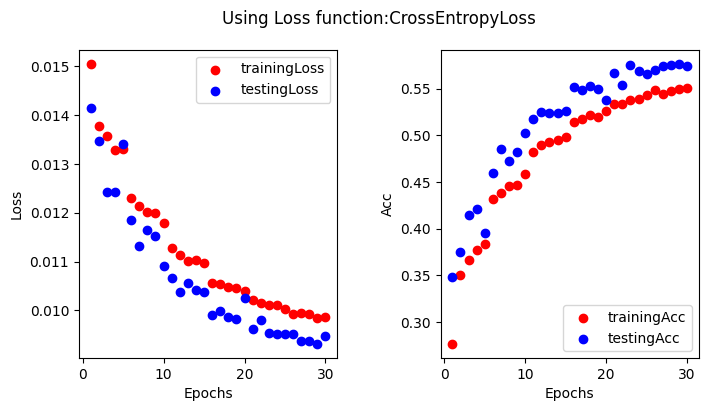

In [19]:
draw_loss(training_loss_1,testing_loss_1,training_acc_1,testing_acc_1,'CrossEntropyLoss')

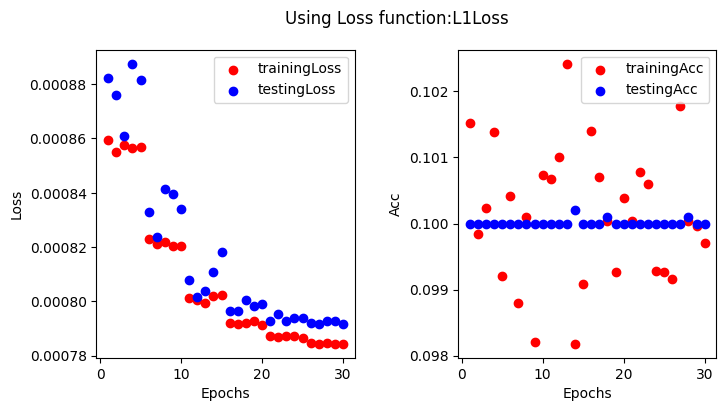

In [20]:
draw_loss(training_loss_2,testing_loss_2,training_acc_2,testing_acc_2,'L1Loss')

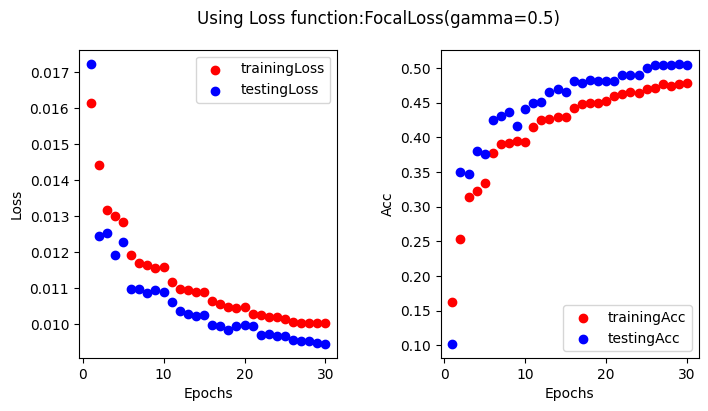

In [21]:
draw_loss(training_loss_3,testing_loss_3,training_acc_3,testing_acc_3,'FocalLoss(gamma=0.5)')

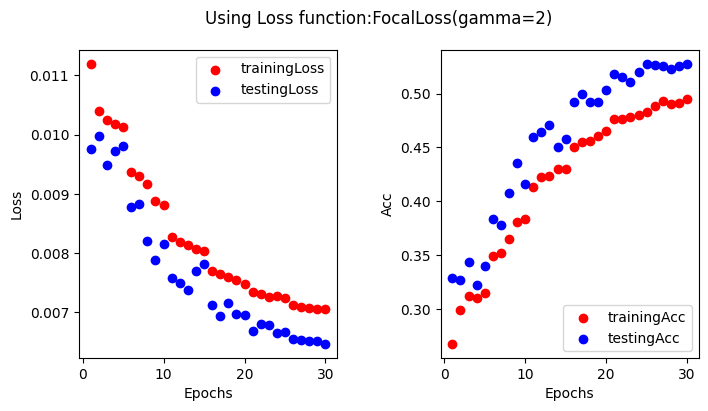

In [22]:
draw_loss(training_loss_4,testing_loss_4,training_acc_4,testing_acc_4,'FocalLoss(gamma=2)')

In [23]:
#Plot Precision
def draw_other(tr1,tr2,tr3,tr4,te1,te2,te3,te4,name):
    x=np.arange(1,31)
    plt.figure(figsize=(8, 4))

    plt.subplot(1,2,1)
    plt.plot(x, tr1, c='red', label='CrossEntropyLoss')
    plt.plot(x, tr2, c='blue',label='L1Loss')
    plt.plot(x, tr3, c='brown',label='FocalLoss(gamma=0.5)')
    plt.plot(x, tr4, c='green',label='FocalLoss(gamma=2)')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.title('TrainingSet')

    plt.subplot(1,2,2)
    plt.plot(x, te1, c='red', label='CrossEntropyLoss')
    plt.plot(x, te2, c='blue',label='L1Loss')
    plt.plot(x, te3, c='brown',label='FocalLoss(gamma=0.5)')
    plt.plot(x, te4, c='green',label='FocalLoss(gamma=2)')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.title('TestingSet')

    plt.suptitle(f'{name} in four loss function')
    plt.subplots_adjust(wspace=0.4)

    plt.show()

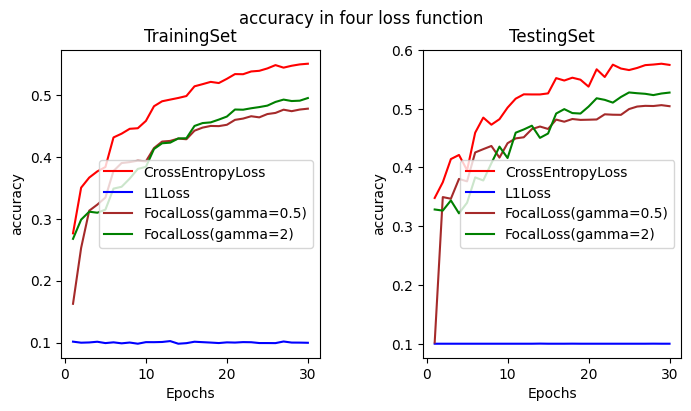

In [24]:
draw_other(training_acc_1,training_acc_2,training_acc_3,training_acc_4,testing_acc_1,testing_acc_2,testing_acc_3,testing_acc_4,'accuracy')

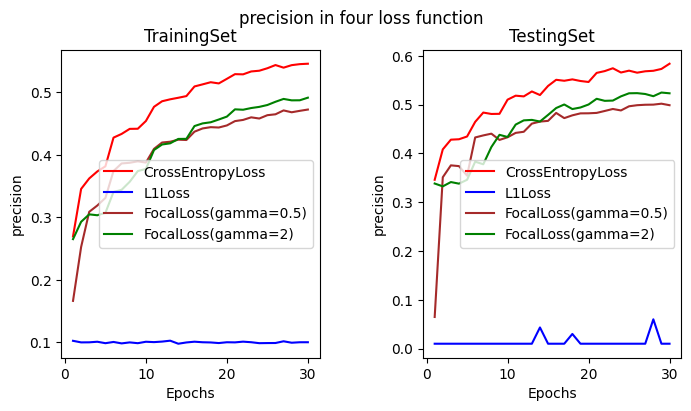

In [25]:
draw_other(training_precision_1,training_precision_2,training_precision_3,training_precision_4,testing_precision_1,testing_precision_2,testing_precision_3,testing_precision_4,'precision')

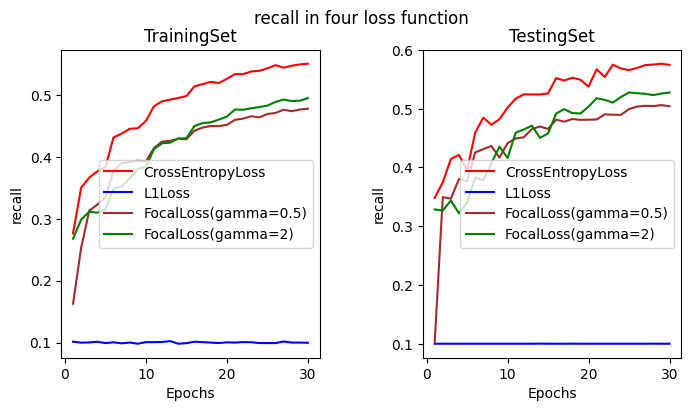

In [26]:
draw_other(training_recall_1,training_recall_2,training_recall_3,training_recall_4,testing_recall_1,testing_recall_2,testing_recall_3,testing_recall_4,'recall')

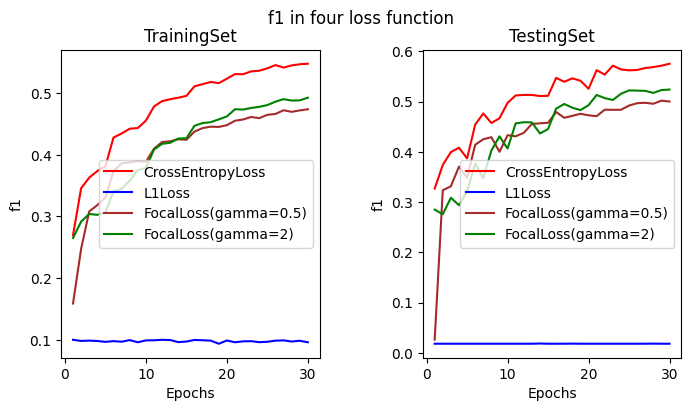

In [27]:
draw_other(training_f1_1,training_f1_2,training_f1_3,training_f1_4,testing_f1_1,testing_f1_2,testing_f1_3,testing_f1_4,'f1')

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [28]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0].to(device)

In [29]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

probabilities = F.softmax(model(input),dim=1)[0,]
_,predict_label = torch.max(model(input),dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


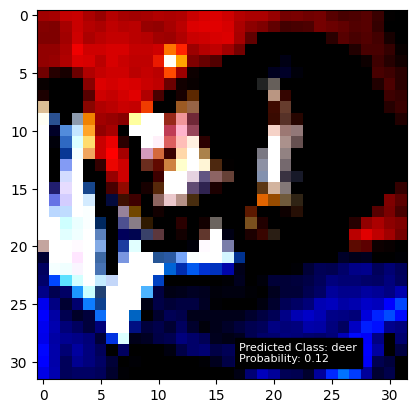

Print probabilities for each class:
airplane: 0.0938
automobile: 0.1153
bird: 0.0859
cat: 0.0919
deer: 0.1244
dog: 0.0914
frog: 0.1237
horse: 0.1044
ship: 0.0784
truck: 0.0906


In [30]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[predict_label].item()
image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[i].item():.4f}')